# Aligning Spectra

This notebook shows why it is necessary to shift spectra before they can be stacked together.

The use case is that for radio recombination lines, altough other lines could also be used for the example.

## Use Case
Observations of radio recombination lines benefit from averaging multiple transitions together, as the line properties change "slowly" with frequency (how slow, is a matter of debate and not the topic of this example). For this example we will look at what would happen if we were to stack two transitions together without shifting (aligning) them before.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import units as u
from dysh.fits.gbtfitsload import GBTFITSLoad

In [2]:
path = "/home/dysh/acceptance_testing/data/"
file1 = f"{path}/AGBT18B_014_02/AGBT18B_014_02.raw.vegas"

In [3]:
sdf = GBTFITSLoad(file1)

Loaded 8 FITS files


In [4]:
sdf.summary()

,SCAN,OBJECT,VELOCITY,PROC,PROCSEQN,RESTFREQ,DOPFREQ,# IF,# POL,# INT,# FEED,AZIMUTH,ELEVATIO
0,6,W43G,92.02,OffOn,1,5.764969,5.93154,64,2,3,1,117.575564,27.647278
1,7,W43G,92.02,OffOn,2,5.764969,5.93154,64,2,3,1,117.172716,27.302879


For simplicity we will only use two spectral windows, 27 and 28, which we know have good data in them.

In [5]:
pssb = sdf.getps(ifnum=[27,30], plnum=0)

/home/sandboxes/psalas/Dysh/dysh/src/dysh/spectra/core.py:395: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])
/home/sandboxes/psalas/Dysh/dysh/src/dysh/spectra/core.py:395: RuntimeWarning: Mean of empty slice
  meandiff = np.nanmean(calon[chrng] - caloff[chrng])


Now we will drop the edge channels, and then fit an order 2 baseline to line free channels. To end we will drop line free channels so we can focus on the emission lines.

In [6]:
s = slice(150,1900)
exclude = [30*u.km/u.s, 150*u.km/u.s]

ta1 = pssb[0].timeaverage().smooth("gauss", 4)[150:1900]
ta1.baseline(model="cheby", degree=2, remove=True, exclude=exclude)
ta2 = pssb[1].timeaverage().smooth("gauss", 4)[150:1900]
ta2.baseline(model="cheby", degree=2, remove=True, exclude=exclude)

s = slice(0*u.km/u.s, 200*u.km/u.s)
ta1 = ta1[s]
ta2 = ta2[s]

EXCLUDING [Spectral Region, 1 sub-regions:
  (5464064707.706556 Hz, 5466252941.541311 Hz) 
]
EXCLUDING [Spectral Region, 1 sub-regions:
  (5716228475.37819 Hz, 5718517695.075638 Hz) 
]


Next, we plot the spectra as a function of velocity and as a function of channel.

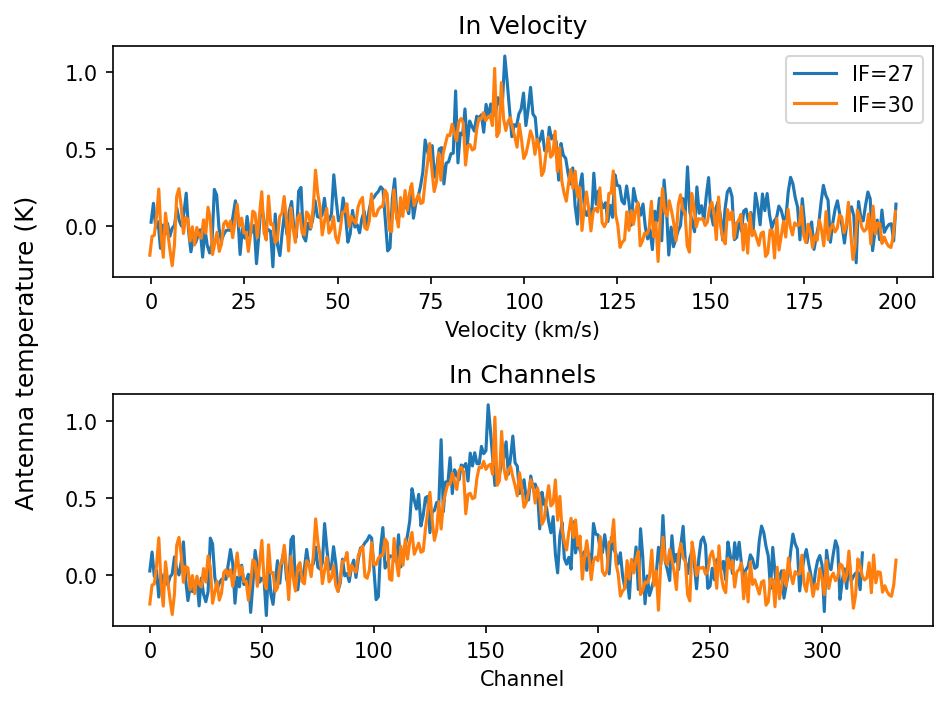

In [7]:
plt.figure(dpi=150)

plt.subplot(211)
plt.title("In Velocity")
plt.plot(ta1.spectral_axis.to("km/s").value, ta1.flux, label=f"IF={ta1.meta['IFNUM']}")
plt.plot(ta2.spectral_axis.to("km/s").value, ta2.flux, label=f"IF={ta2.meta['IFNUM']}")
plt.legend()
plt.xlabel("Velocity (km/s)")

plt.subplot(212)
plt.title("In Channels")
plt.plot(ta1.flux)
plt.plot(ta2.flux)
plt.xlabel("Channel")

plt.gcf().supylabel("Antenna temperature (K)")

plt.tight_layout()


The difference is subtle, but the top panel shows that the spectral line is well aligned in velocity, whereas the bottom panel shows that the line centroids are slightly misaligned. If we were to average the two spectra together, the resulting line would look artificially broader than it is!